# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
! pip install keras-tuner
! pip install tensorflow
! pip install tensorflow-addons

In [148]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#  TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


import os

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [149]:
# Define a function to load data and aggregate them

def load_and_aggregate_data(directory_path):
    combined_df = []

    for file in os.listdir(directory_path):
        if not file.endswith('.csv'):
            continue
        # Get stock name from the file name
        stock_name = file.split('_')[0]

        print(f"Loading data for {stock_name}...")

        df = pd.read_csv(os.path.join(directory_path, file))  # Load the CSV file
        df['Name'] = stock_name  # Add a new column for stock name
        combined_df.append(df)

    return pd.concat(combined_df, ignore_index=True)  # Concatenate the dataframes

In [150]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

combined_df = load_and_aggregate_data(directory_path='RNN_Stocks_Data')
combined_df

Loading data for AMZN...
Loading data for GOOGL...
Loading data for IBM...
Loading data for MSFT...


Date   Open   High    Low  Close    Volume  Name
0      2006-01-03  47.47  47.85  46.25  47.58   7582127  AMZN
1      2006-01-04  47.48  47.73  46.69  47.25   7440914  AMZN
2      2006-01-05  47.16  48.20  47.11  47.65   5417258  AMZN
3      2006-01-06  47.97  48.58  47.32  47.87   6154285  AMZN
4      2006-01-09  46.55  47.10  46.40  47.08   8945056  AMZN
...           ...    ...    ...    ...    ...       ...   ...
12072  2017-12-22  85.40  85.63  84.92  85.51  14145841  MSFT
12073  2017-12-26  85.31  85.53  85.03  85.40   9891237  MSFT
12074  2017-12-27  85.65  85.98  85.22  85.71  14678025  MSFT
12075  2017-12-28  85.90  85.93  85.55  85.72  10594344  MSFT
12076  2017-12-29  85.63  86.05  85.50  85.54  18717406  MSFT

[12077 rows x 7 columns]

In [151]:
# View specifics of the data
print(combined_df.head())  # Display the first 5 rows of the combined DataFrame
print(combined_df.tail())  # Display the last 5 rows of the combined DataFrame
print(combined_df.shape)  # Display the shape of the DataFrame (rows, columns)
print(combined_df.info())  # Display information about the DataFrame
print(combined_df.groupby('Name').describe())  # Display descriptive statistics of the DataFrame



         Date   Open   High    Low  Close   Volume  Name
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN
             Date   Open   High    Low  Close    Volume  Name
12072  2017-12-22  85.40  85.63  84.92  85.51  14145841  MSFT
12073  2017-12-26  85.31  85.53  85.03  85.40   9891237  MSFT
12074  2017-12-27  85.65  85.98  85.22  85.71  14678025  MSFT
12075  2017-12-28  85.90  85.93  85.55  85.72  10594344  MSFT
12076  2017-12-29  85.63  86.05  85.50  85.54  18717406  MSFT
(12077, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 

In [152]:
# Check for missing values in the DataFrame
print(combined_df.isnull().sum())

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [153]:
# Handle Missing Values
combined_df.dropna(inplace=True)  # Drop rows with missing values

In [154]:
# Check for missing values in the DataFrame after handling them
print(combined_df.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

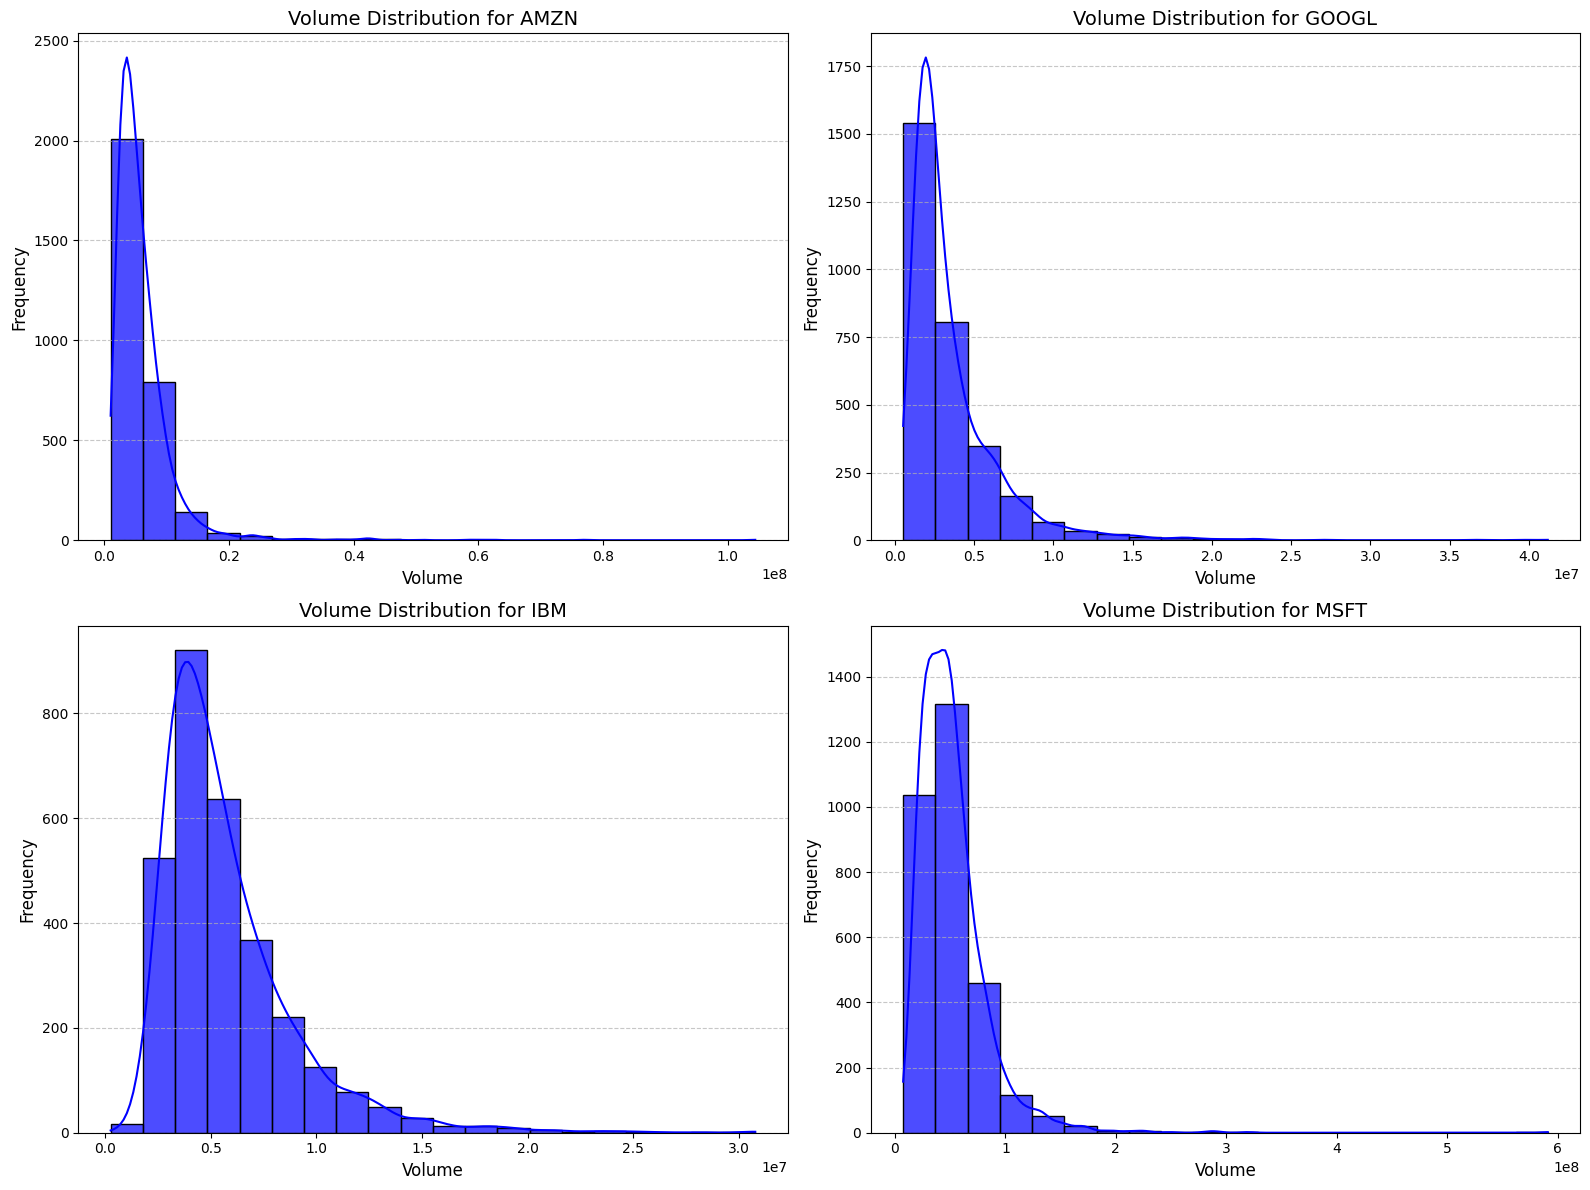

In [155]:
# Generate separate charts for each stock
stock_names = combined_df['Name'].unique()  # Get unique stock names

plt.figure(figsize=(16, 12))

for i, stock in enumerate(stock_names, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    stock_data = combined_df[combined_df['Name'] == stock]  # Filter data for the stock
    sns.histplot(stock_data['Volume'], kde=True, bins=20, color='blue', alpha=0.7)
    plt.title(f'Volume Distribution for {stock}', fontsize=14)
    plt.xlabel('Volume', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

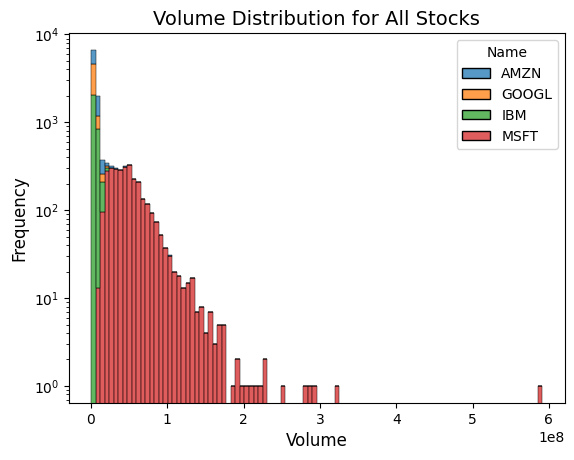

In [156]:
# Combined all stocks into a single histogram
sns.histplot(data=combined_df, x='Volume', bins=100, hue='Name', color='blue', multiple='stack')
plt.title('Volume Distribution for All Stocks', fontsize=14)
plt.xlabel('Volume', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

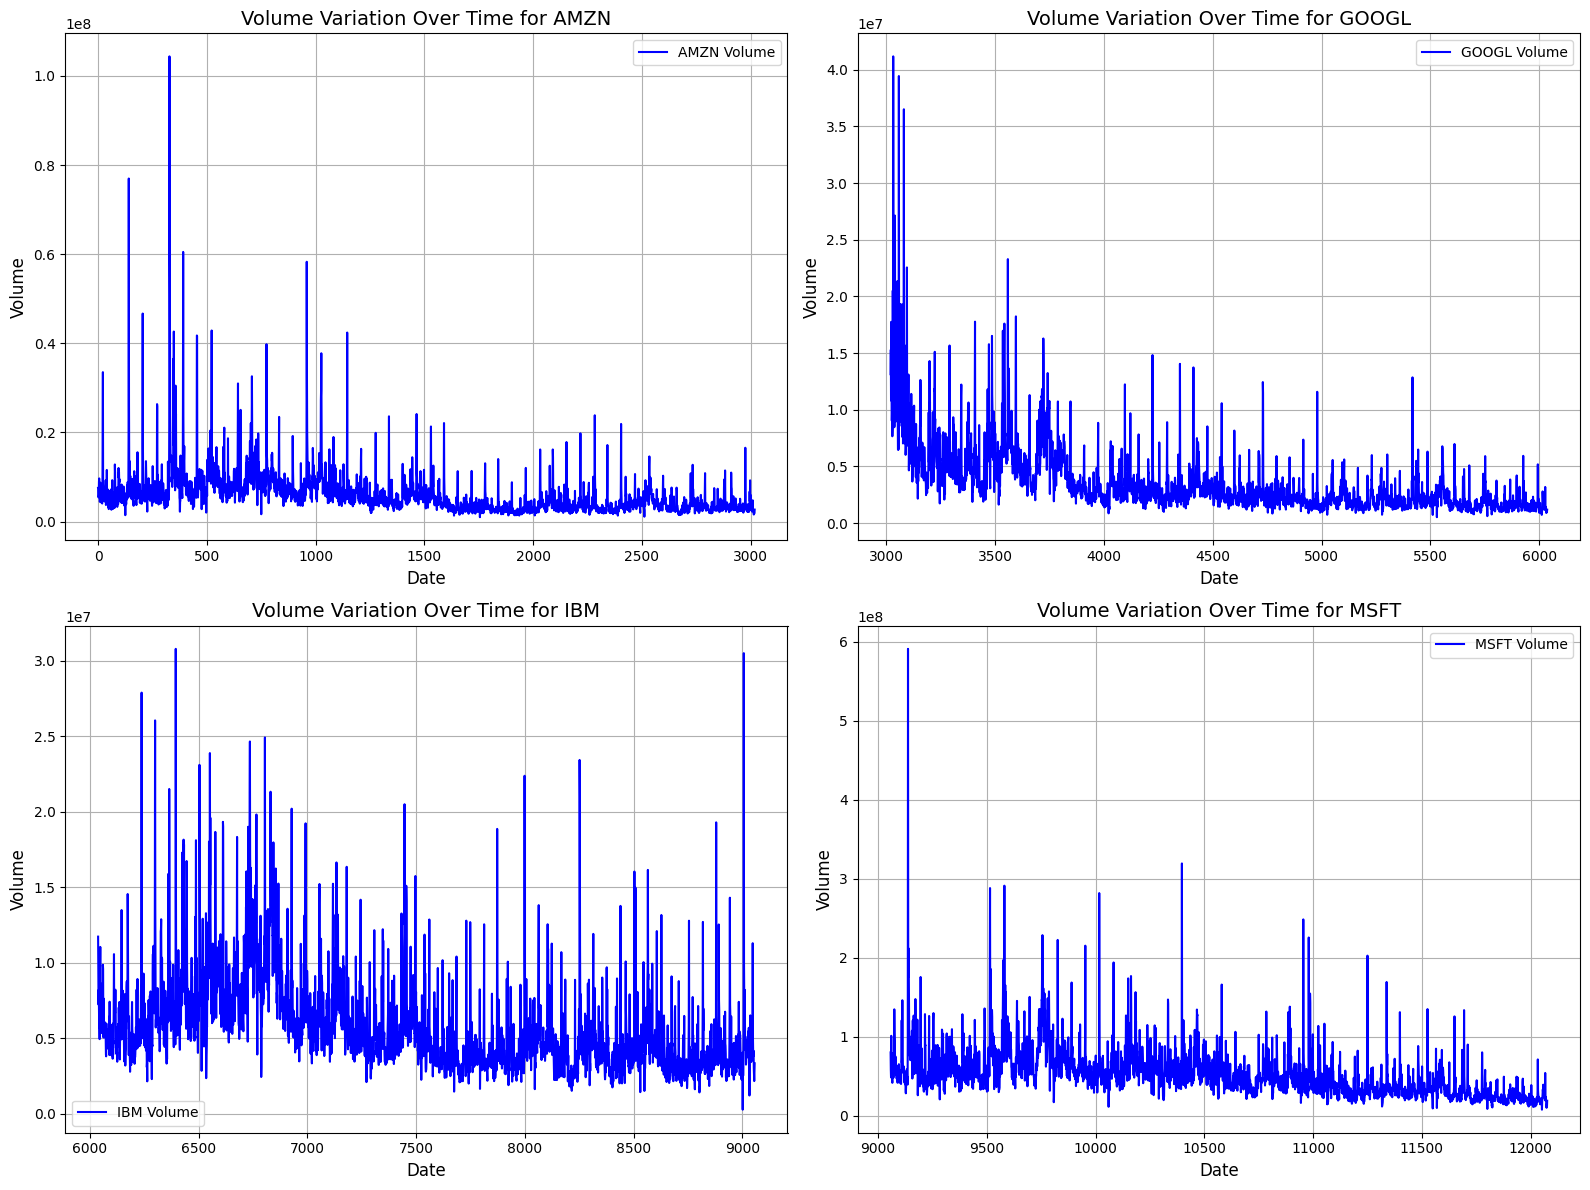

In [157]:
# Stock volume variation over time

plt.figure(figsize=(16, 12))

for i, stock in enumerate(stock_names, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    stock_data = combined_df[combined_df['Name'] == stock]  # Filter data for the stock
    plt.plot(stock_data.index, stock_data['Volume'], label=f'{stock} Volume', color='blue')
    plt.title(f'Volume Variation Over Time for {stock}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Volume', fontsize=12)
    plt.legend()
    plt.grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

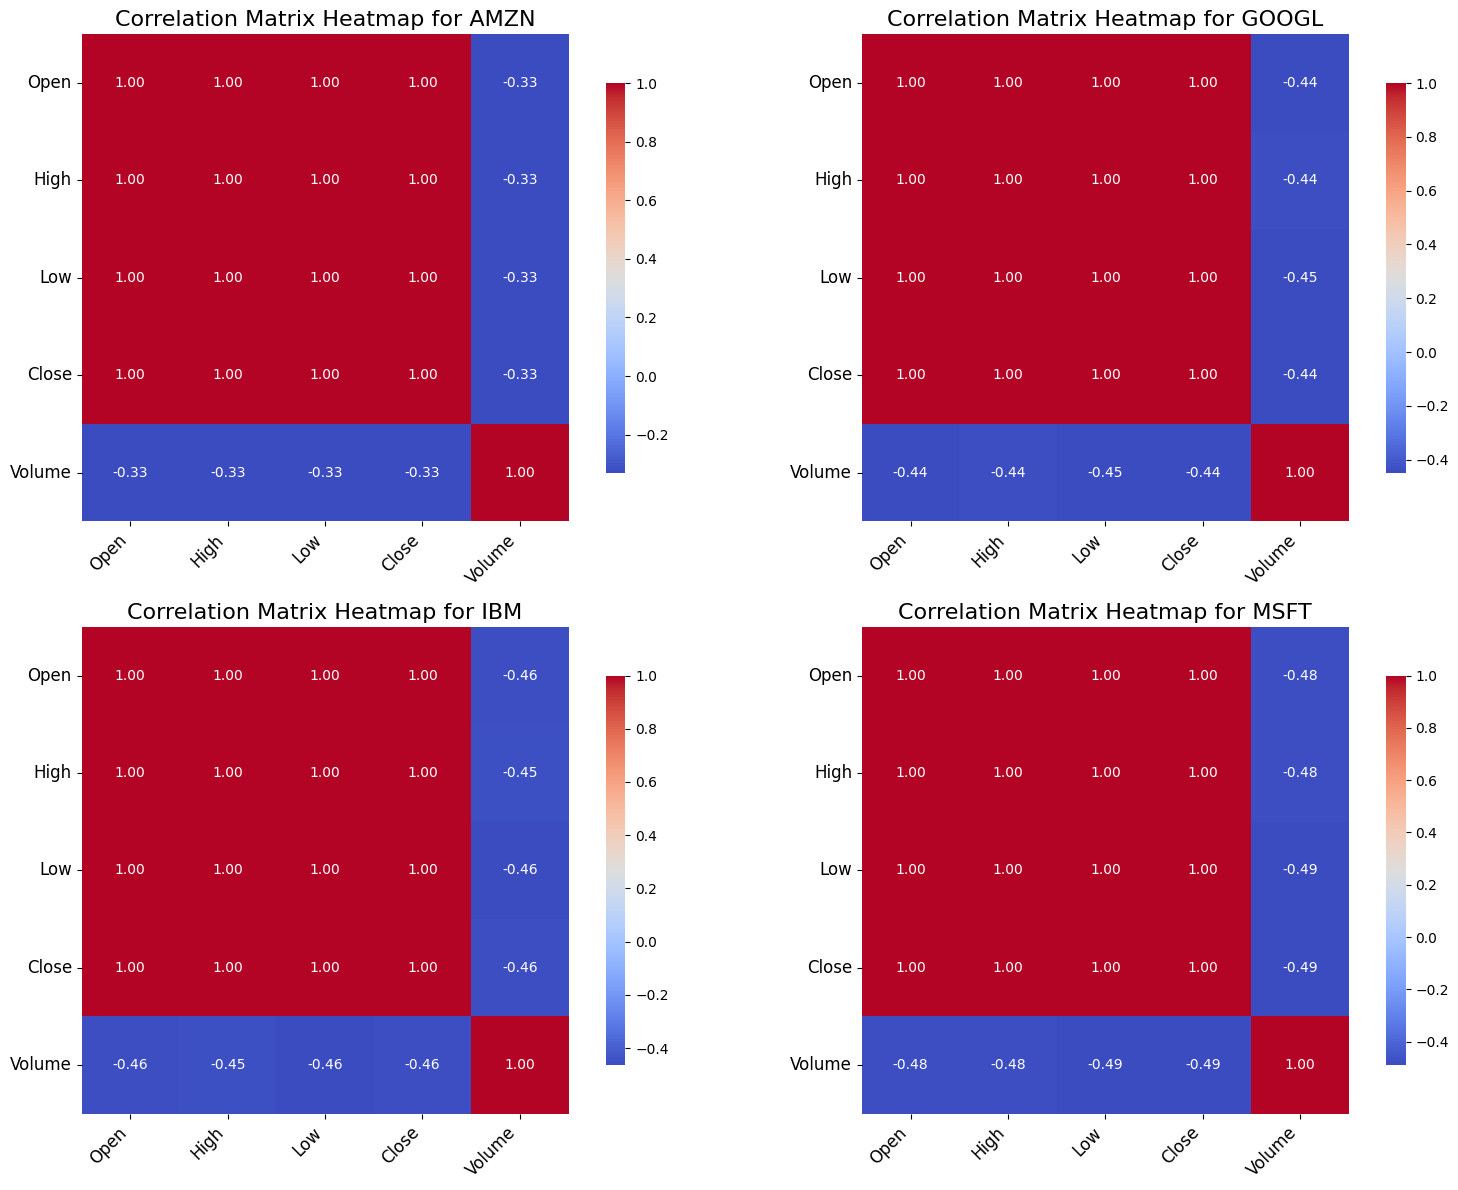

In [158]:
# Analyse correlations
plt.figure(figsize=(16, 12))

for i, stock in enumerate(stock_names, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    stock_df = combined_df[combined_df['Name'] == stock].sort_values(by='Date').set_index('Date')  # Filter data for the stock and set 'Date' as index
    corr_df = stock_df.drop(columns=['Name'])  # Drop the 'Stock_Name' column for correlation analysis
    corr_matrix = corr_df.corr()  # Calculate the correlation matrix
    # Plot the heatmap of the correlation matrix
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title(f'Correlation Matrix Heatmap for {stock}', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [161]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windowed_data(data, window_size, targetcolumn='Close'):    
    X, y = [], []  # Initialize empty lists for features and target variables
    
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][targetcolumn])
    return np.array(X),np.array(y)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [160]:
# Define a function that scales the windowed data

def scale_data(data):
    scaler=MinMaxScaler()
    scaled_data=scaler.fit_transform(data)
    return scaler, scaled_data

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [163]:
# Define a function to create input and output data points from the master DataFrame

def prepare_data(data, window_size, target_column = 'Close', test_size=0.2):
    X, y = create_windowed_data(data, window_size, target_column)  # Create windowed data
    train_size = int(len(X) * (1 - test_size))  # Calculate the training size
    X_train, X_test = X[:train_size], X[train_size:]  # Split the data into training and testing sets
    y_train, y_test = y[:train_size], y[train_size:]  # Split the target variable into training and testing sets
    return X_train, X_test, y_train, y_test  # Return the scaled data and target scaler


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

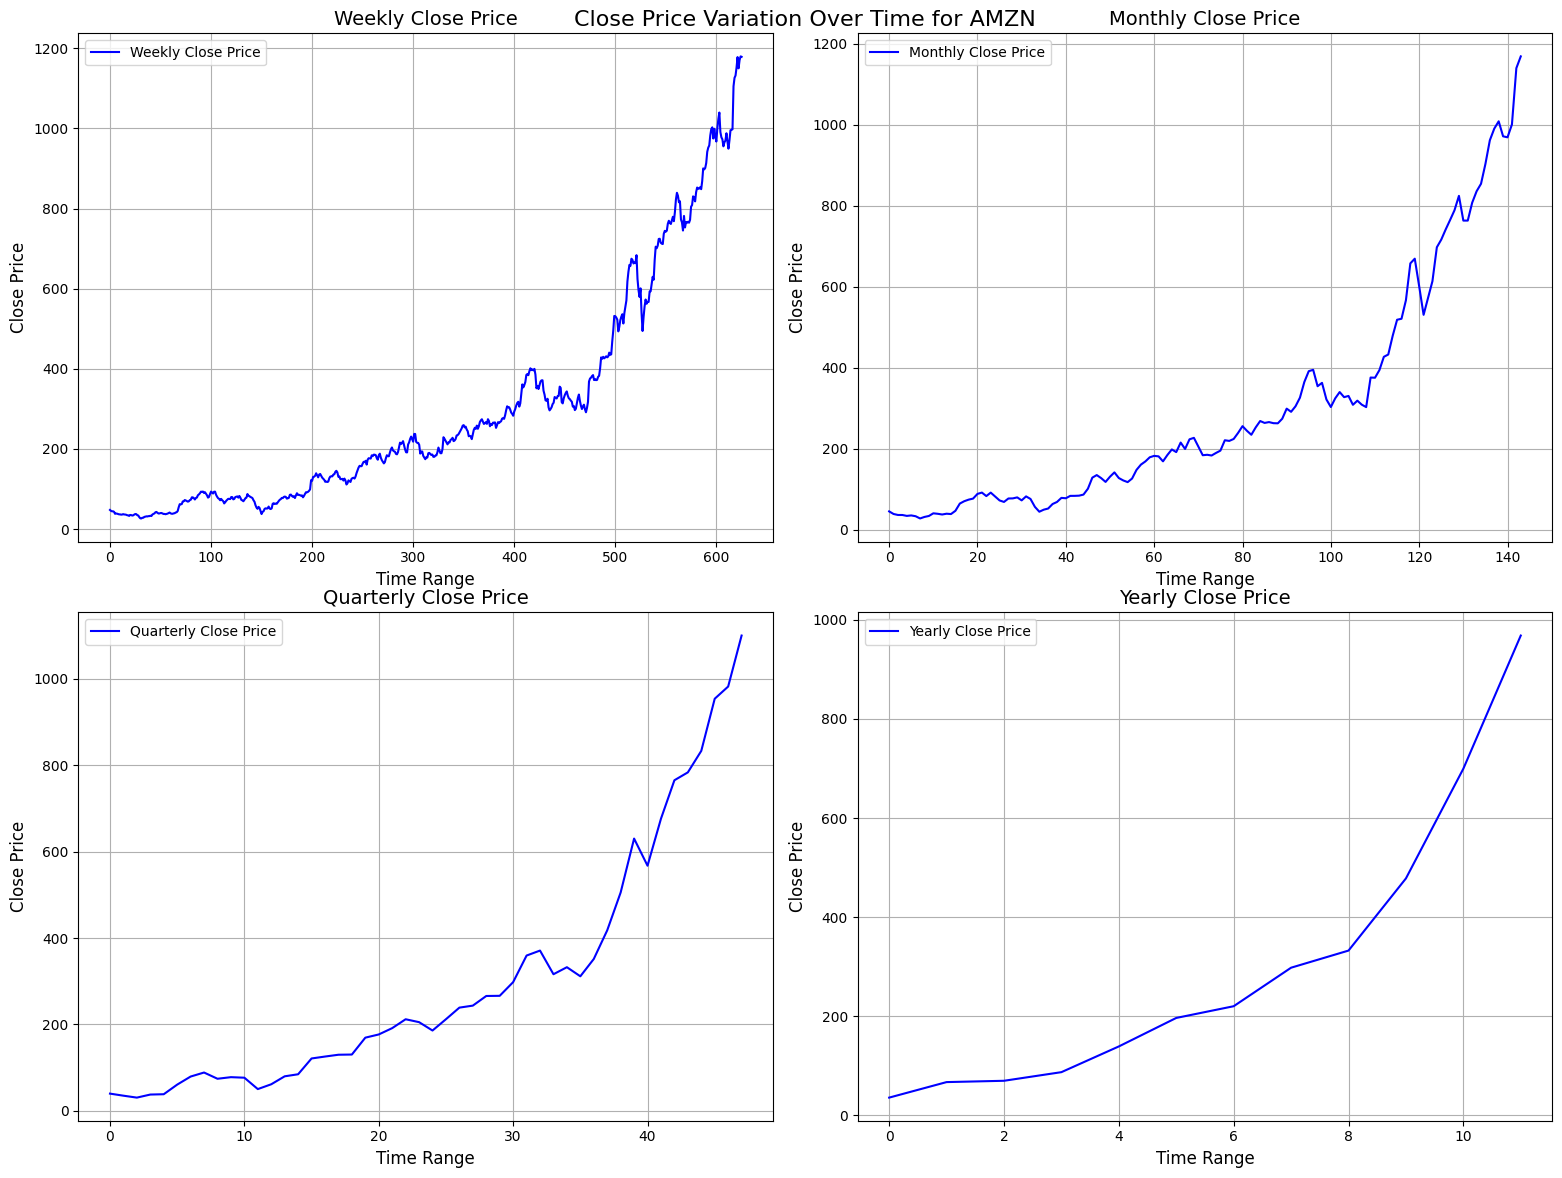

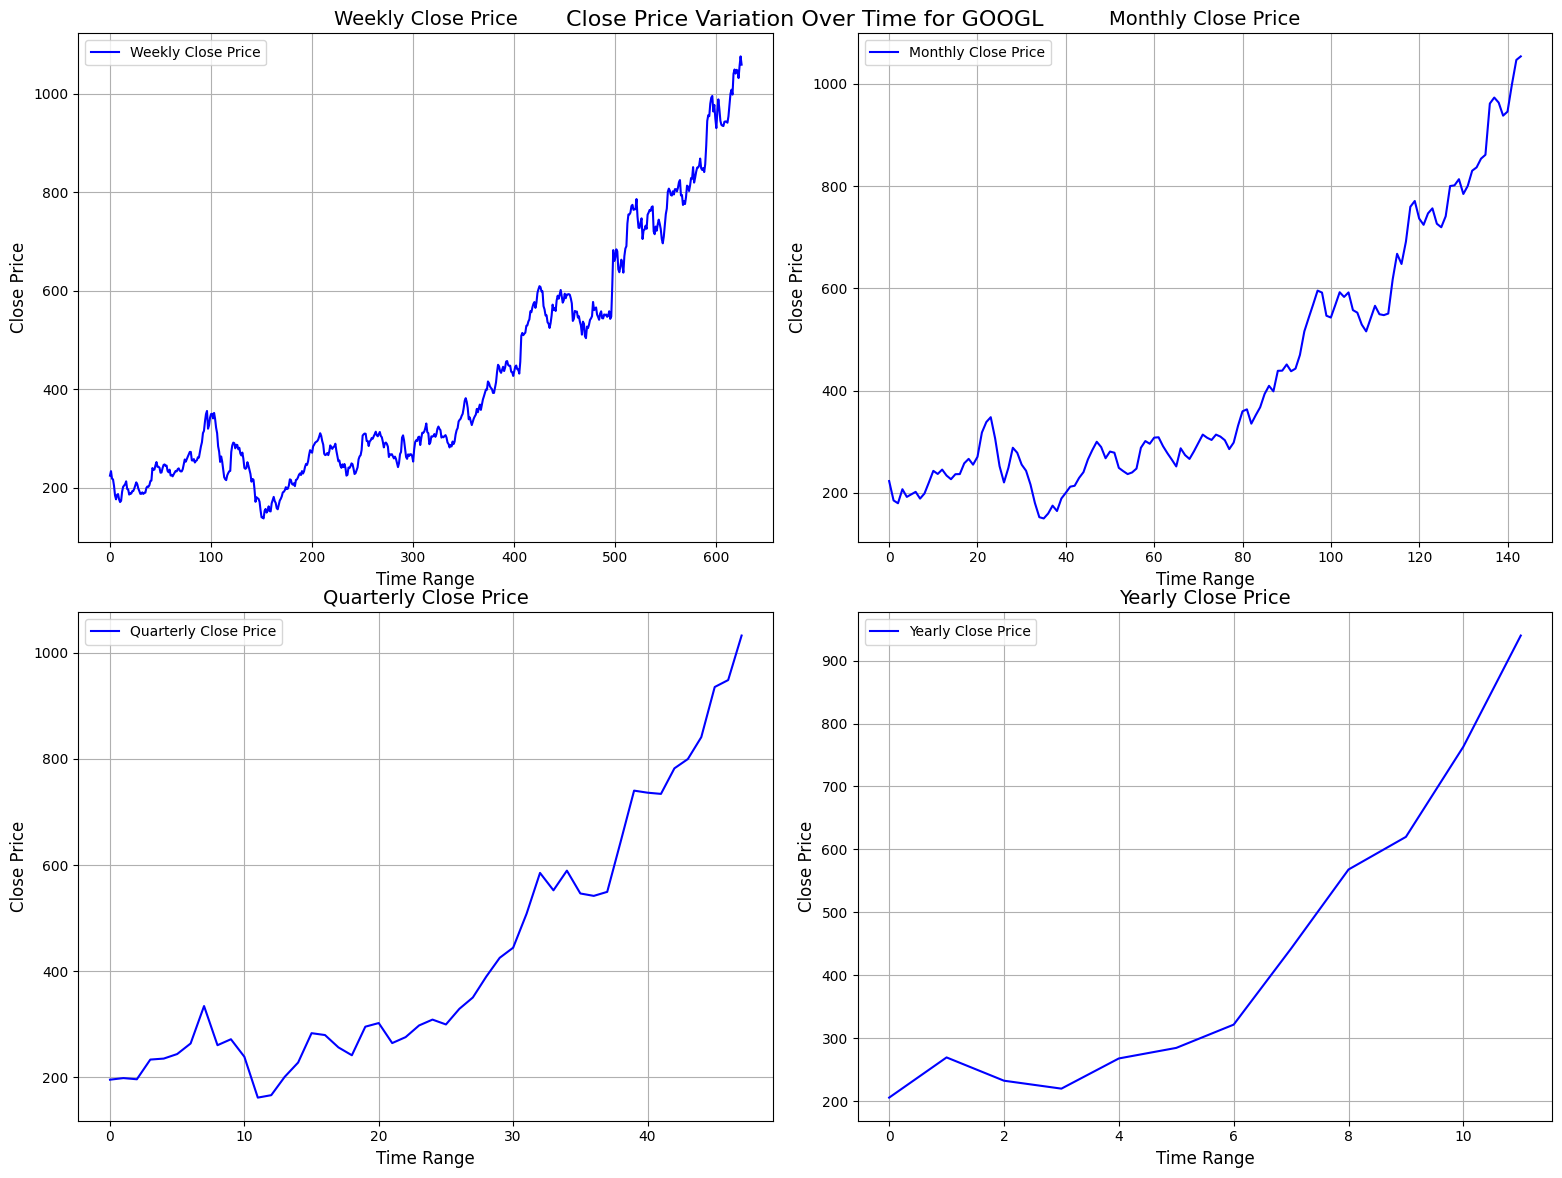

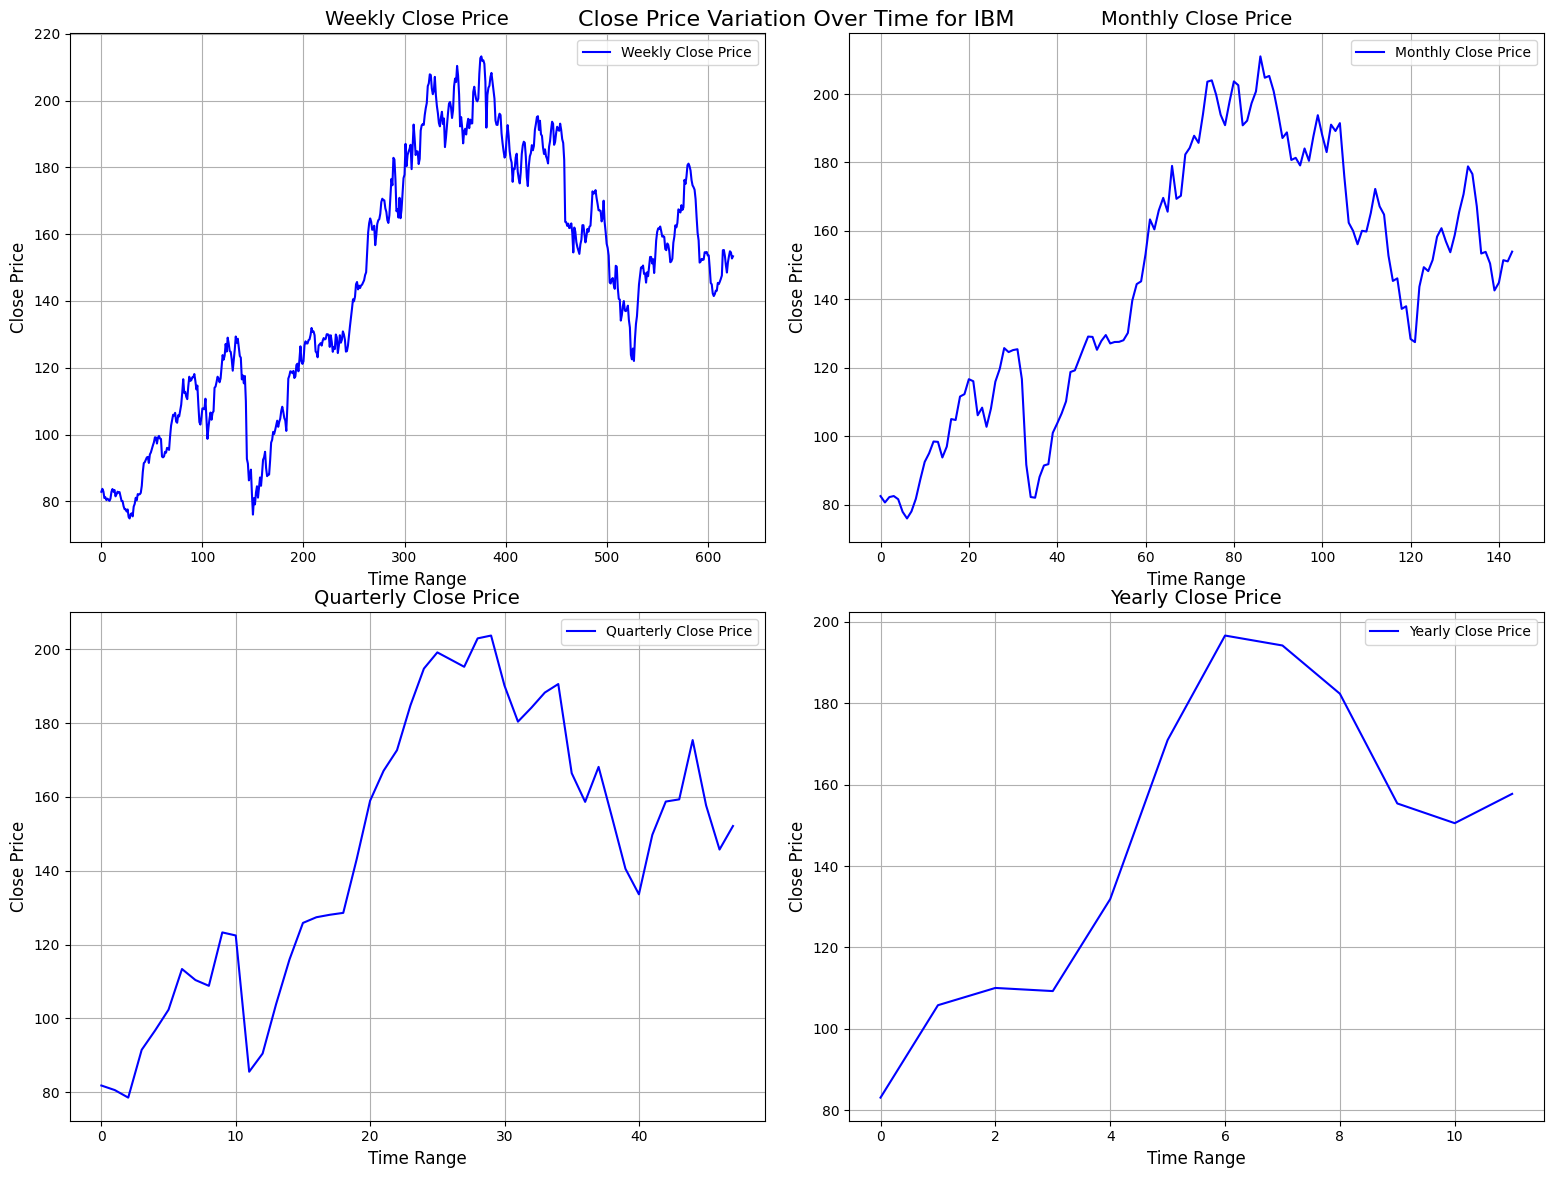

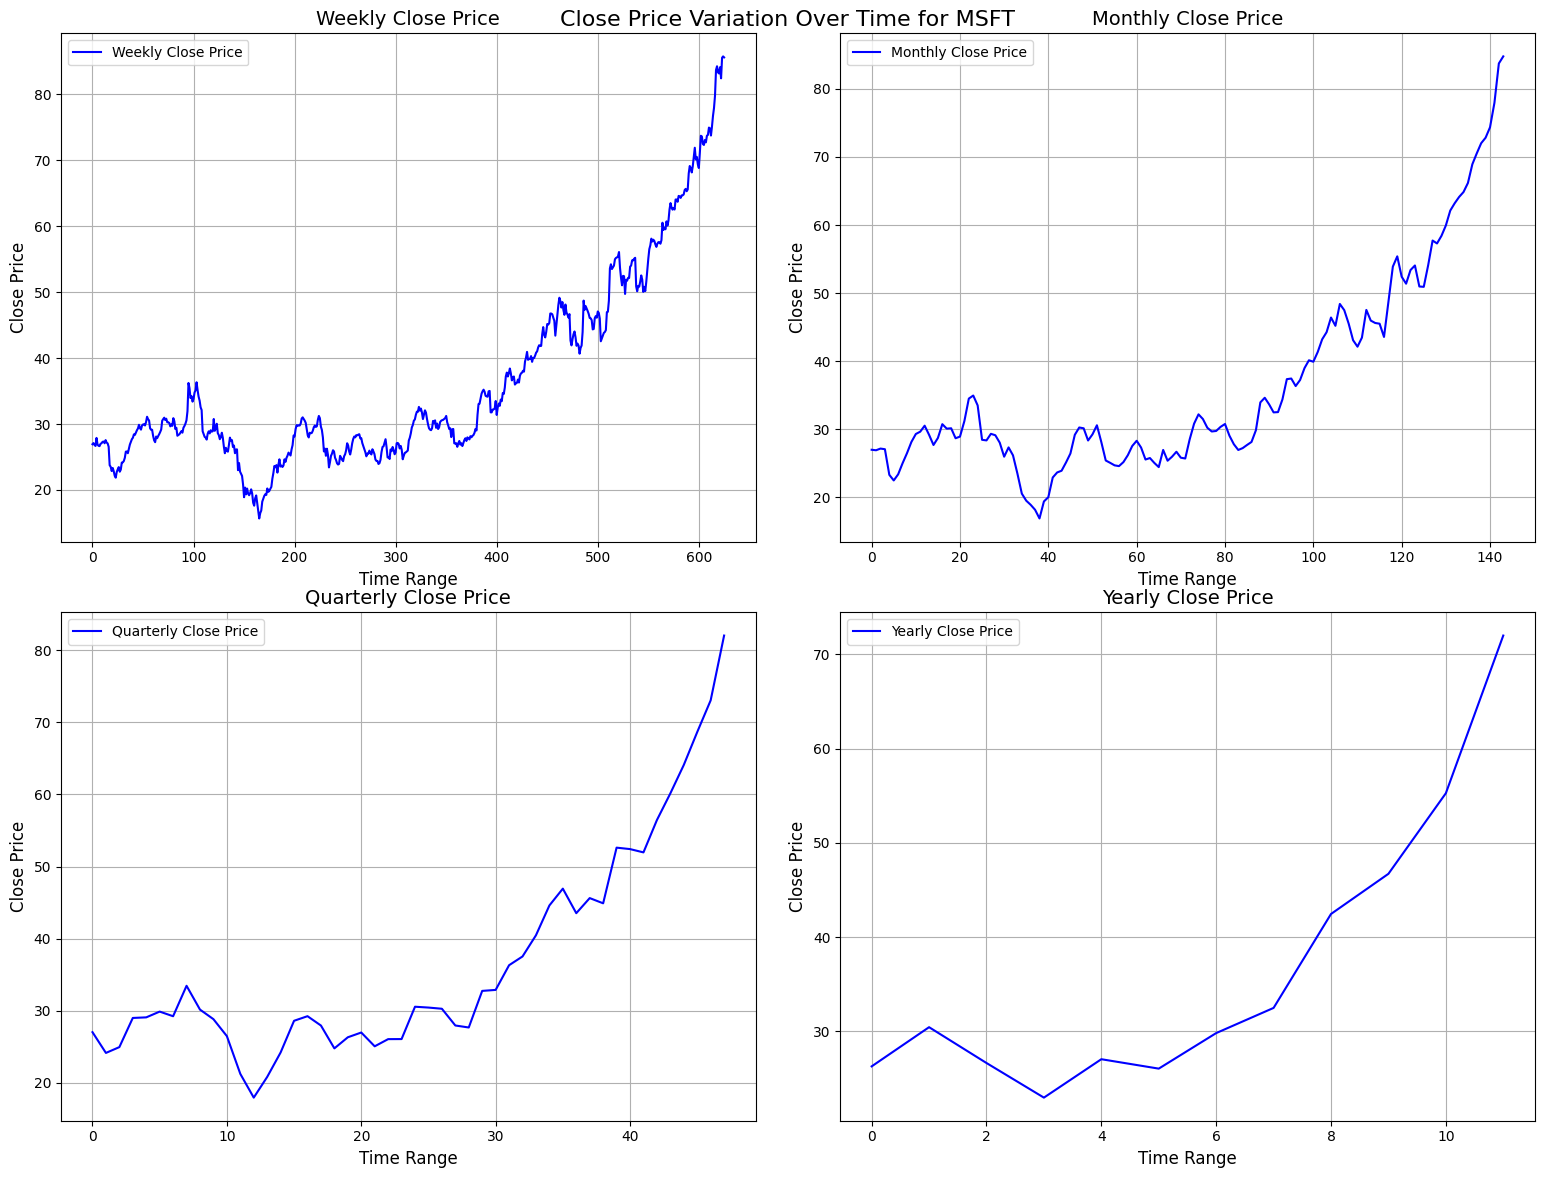

In [164]:
# Checking for patterns in different sequence lengths
window_sizes = ['W', 'M', 'Q', 'Y']
window_names = ['Weekly', 'Monthly', 'Quarterly', 'Yearly']
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
for stock in stock_names:
    sub_data = combined_df[combined_df['Name']==stock].sort_values(by='Date').set_index('Date')  # Filter data for the stock and set 'Date' as index
    fig, axs = plt.subplots(2, 2, figsize=(16,12))  # Create a 2x2 grid of subplots
    fig.tight_layout(pad=3.0)  # Adjust layout to prevent overlap
    fig.suptitle(f'Close Price Variation Over Time for {stock}', fontsize=16)  # Set title
    for window, ax, lbl in zip(window_sizes, axs.ravel(), window_names):
        # stock_data = sub_data['Close'].rolling(window=window).mean()
        stock_data = sub_data.resample(window)['Close'].mean()
        ax.plot(range(0, len(stock_data)), stock_data, label=f'{lbl} Close Price', color='blue')
        ax.set_title(f'{lbl} Close Price', fontsize=14)
        ax.set_xlabel('Time Range', fontsize=12)
        ax.set_ylabel('Close Price', fontsize=12)
        ax.legend()
        ax.grid()
    

    plt.show()  # Show the plot


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [165]:
# Create data instances from the master data frame using decided window size and window stride
window_size = 30
target_column='Close'
for stock in stock_names:
    stock_data = combined_df[combined_df['Name'] == stock][['Open','High','Low','Close','Volume']]  # Filter data for the stock
    scaler, scaled_data = scale_data(stock_data)  # Scale the data
    X_train, X_test, y_train, y_test = prepare_data(scaled_data, window_size, target_column=stock_data.columns.get_loc(target_column))  # Prepare the data
    print(f"\n{stock} Data:")
    print(f"X_train shape: {X_train.shape}")  # Print the shape of the training data
    print(f"X_test shape: {X_test.shape}")  # Print the shape of the testing data
    print(f"y_train shape: {y_train.shape}")  # Print the shape of the training target variable
    print(f"y_test shape: {y_test.shape}")  # Print the shape of the testing target variable


AMZN Data:
X_train shape: (2391, 30, 5)
X_test shape: (598, 30, 5)
y_train shape: (2391,)
y_test shape: (598,)

GOOGL Data:
X_train shape: (2391, 30, 5)
X_test shape: (598, 30, 5)
y_train shape: (2391,)
y_test shape: (598,)

IBM Data:
X_train shape: (2391, 30, 5)
X_test shape: (598, 30, 5)
y_train shape: (2391,)
y_test shape: (598,)

MSFT Data:
X_train shape: (2391, 30, 5)
X_test shape: (598, 30, 5)
y_train shape: (2391,)
y_test shape: (598,)


In [169]:
# Check the number of data points generated
# AMZN processing
stock_name = 'AMZN'
stock_data = combined_df[combined_df['Name'] == stock_name][['Open','High','Low','Close','Volume']]  # Filter data for the stock
target_scalar, scaled_data = scale_data(stock_data.values)  # Scale the data
X_train_amzn, X_test_amzn, y_train_amzn, y_test_amzn = prepare_data(scaled_data, window_size, target_column=stock_data.columns.get_loc(target_column))  # Prepare the data

# GOOGL processing
stock_name = 'GOOGL'
stock_data = combined_df[combined_df['Name'] == stock_name][['Open','High','Low','Close','Volume']]  # Filter data for the stock
target_scalar, scaled_data = scale_data(stock_data.values)  # Scale the data
X_train_googl, X_test_googl, y_train_googl, y_test_googl = prepare_data(scaled_data, window_size, target_column=stock_data.columns.get_loc(target_column))  # Prepare the data

# AAPL processing
stock_name = 'MSFT'
stock_data = combined_df[combined_df['Name'] == stock_name][['Open','High','Low','Close','Volume']]  # Filter data for the stock
target_scalar, scaled_data = scale_data(stock_data.values)  # Scale the data
X_train_msft, X_test_msft, y_train_msft, y_test_msft = prepare_data(scaled_data, window_size, target_column=stock_data.columns.get_loc(target_column))  # Prepare the data

# IBM processing
stock_name = 'IBM'
stock_data = combined_df[combined_df['Name'] == stock_name][['Open','High','Low','Close','Volume']]  # Filter data for the stock
target_scalar, scaled_data = scale_data(stock_data.values)  # Scale the data
X_train_ibm, X_test_ibm, y_train_ibm, y_test_ibm = prepare_data(scaled_data, window_size, target_column=stock_data.columns.get_loc(target_column))  # Prepare the data



**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [170]:
# Check if the datasets are compatible inputs to neural networks

print("\nAmazon")
print(f"X_train:{X_train_amzn.shape}\ny_train:{y_train_amzn.shape}")
print(f"X_test:{X_test_amzn.shape}\ny_test:{y_test_amzn.shape}")

print("\nGoogle")
print(f"X_train:{X_train_googl.shape}\ny_train:{y_train_googl.shape}")
print(f"X_test:{X_test_googl.shape}\ny_test:{y_test_googl.shape}")

print("\nMicrosoft")
print(f"X_train:{X_train_msft.shape}\ny_train:{y_train_msft.shape}")
print(f"X_test:{X_test_msft.shape}\ny_test:{y_test_msft.shape}")

print("\nIBM")
print(f"X_train:{X_train_ibm.shape}\ny_train:{y_train_ibm.shape}")
print(f"X_test:{X_test_ibm.shape}\ny_test:{y_test_ibm.shape}")


Amazon
X_train:(2391, 30, 5)
y_train:(2391,)
X_test:(598, 30, 5)
y_test:(598,)

Google
X_train:(2391, 30, 5)
y_train:(2391,)
X_test:(598, 30, 5)
y_test:(598,)

Microsoft
X_train:(2391, 30, 5)
y_train:(2391,)
X_test:(598, 30, 5)
y_test:(598,)

IBM
X_train:(2391, 30, 5)
y_train:(2391,)
X_test:(598, 30, 5)
y_test:(598,)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [172]:
# Create a function that creates a simple RNN model according to the model configuration arguments

# creating simple RRN model
def create_simple_rnn_model(window_size, num_features, units=50):
    model = Sequential([
        SimpleRNN(units, activation='relu', input_shape=(window_size, num_features)),
        Dense(1),
    ])
    model.compile(optimizer='adam', loss='mse')
    return model
    

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [173]:
# Find an optimal configuration of simple RNN

def find_optimal_rnn_config(X_train, y_train, X_test, y_test, window_size, num_features, unitoptions=[30,50,70], epochs=20, batch_size=32):
    best_model=None
    bestval_loss=float('inf')
    history={}
    for units in unitoptions:
        print(f"\nTraining simple RNN with {units} units")
        model=create_simple_rnn_model(window_size,num_features,units=units)
        modelhis=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test),verbose=0)
        val_loss=modelhis.history['val_loss'][-1]
        history[units]=modelhis.history
        print(f"Validation loss for {units} units:{val_loss:.4f}")
        if val_loss<bestval_loss:
            bestval_loss=val_loss
            best_model=model
    print(f"\nBest simple RNN validation loss:{bestval_loss:.4f} with {best_model.layers[0].units} units.")
    return best_model,history

num_features = X_train.shape[2]  # Get the number of features from the training data
best_model, model_history = find_optimal_rnn_config(X_train,y_train,X_test,y_test,window_size,num_features)  # Find the optimal RNN configuration



Training simple RNN with 30 units
Validation loss for 30 units:0.0009

Training simple RNN with 50 units
Validation loss for 50 units:0.0005

Training simple RNN with 70 units
Validation loss for 70 units:0.0003

Best simple RNN validation loss:0.0003 with 70 units.


In [54]:
# Find the best configuration based on evaluation metrics

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [174]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

val_predictions = best_model.predict(X_test)  # Make predictions on the test data
real_predict = target_scalar.inverse_transform(np.concatenate((X_test[:,-1,:-1], val_predictions), axis=1))[:,-1]
real_y_val = target_scalar.inverse_transform(np.concatenate((X_test[:,-1,:-1], y_test.reshape(-1,1)), axis=1))[:,-1]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Plotting the actual vs predicted values

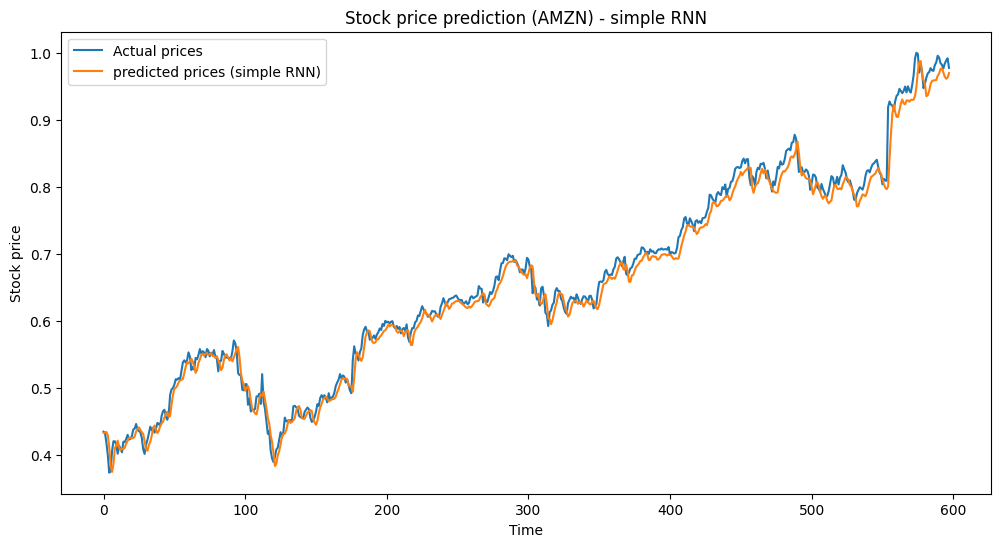

In [175]:
# Predict on the test data and plot
stockname='AMZN'
plt.figure(figsize=(12,6))
plt.plot(y_test,label='Actual prices')
plt.plot(val_predictions,label='predicted prices (simple RNN)')
plt.title(f'Stock price prediction ({stockname}) - simple RNN')
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [176]:
# Compute the performance of the model on the testing data set
rmse_srnn=np.sqrt(mean_squared_error(real_y_val,real_predict))
print(f"Root mean squared error (simple RNN):{rmse_srnn:.2f}")


Root mean squared error (simple RNN):502839.13


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [177]:
# # Define a function to create a model and specify default values for hyperparameters

def lstmmodel(windowsize,num_features,units=50):
    model=Sequential([
        LSTM(units=units,return_sequences=True,activation='relu',input_shape=(windowsize,num_features)),
        LSTM(units=units,activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam',loss='mse')
    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [178]:
# Find an optimal configuration

def tune_lst_mmodel(X_train,y_train, X_test, y_test,window_size,num_features,unitoption=[30,50,70],epochs=20,batch_size=32):
    best_model=None
    bestval_loss=float('inf')
    history={}
    for units in unitoption:
        print(f"\nTraining LSTM with {units} units")
        model=lstmmodel(window_size,num_features,units=units)
        modelhis=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test),verbose=0)
        val_loss=modelhis.history['val_loss'][-1]
        history[units]=modelhis.history
        print(f"Validation loss for {units} units:{val_loss:.4f}")
        if val_loss<bestval_loss:
            bestval_loss=val_loss
            best_model=model
    print(f"\nBest LSTM validation loss:{bestval_loss:.4f} with {best_model.layers[0].units} units.")
    return best_model, history
best_lstmmodel, lstm_history = tune_lst_mmodel(X_train, y_train, X_test, y_test, window_size, num_features)


Training LSTM with 30 units
Validation loss for 30 units:0.0045

Training LSTM with 50 units
Validation loss for 50 units:0.0007

Training LSTM with 70 units
Validation loss for 70 units:0.0014

Best LSTM validation loss:0.0007 with 50 units.


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [ ]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model



In [179]:
# Compute the performance of the model on the testing data set
val_predictions = best_lstmmodel.predict(X_test)  # Make predictions on the test data
real_predict_lstm = target_scalar.inverse_transform(np.concatenate((X_test[:,-1,:-1], val_predictions), axis=1))[:,-1]
real_y_val = target_scalar.inverse_transform(np.concatenate((X_test[:,-1,:-1], y_test.reshape(-1,1)), axis=1))[:,-1]

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


Plotting the actual vs predicted values

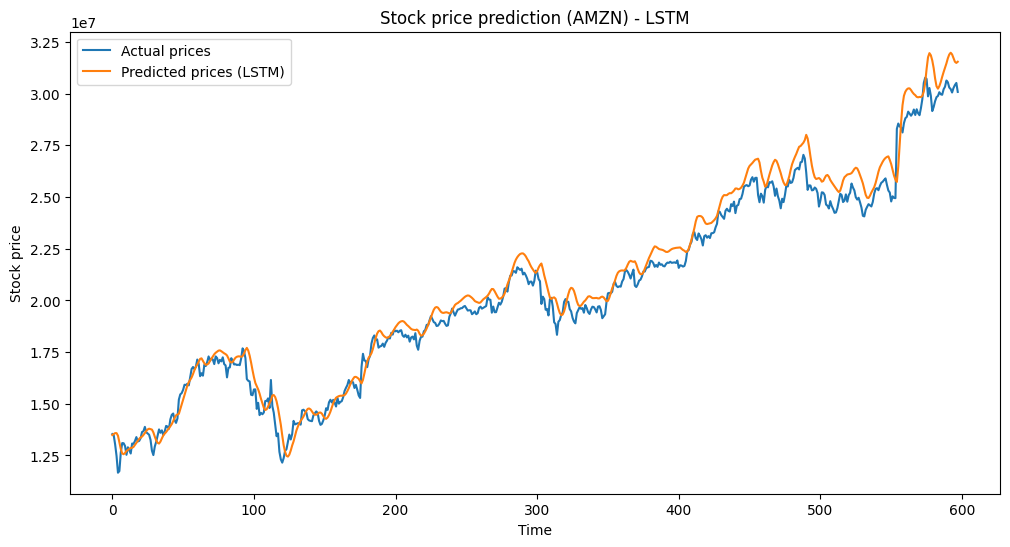

In [180]:
# Predict on the test data
plt.figure(figsize=(12,6))
plt.plot(real_y_val,label='Actual prices')
plt.plot(real_predict_lstm,label='Predicted prices (LSTM)')
plt.title(f'Stock price prediction ({stockname}) - LSTM')
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [34]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [35]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [36]:
# Find an optimal configuration of simple RNN



In [37]:
# Find the best configuration



In [38]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [39]:
# Compute the performance of the model on the testing data set



In [40]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [41]:
# Find an optimal configuration of advanced RNN



In [42]:
# Find the best configuration



In [43]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [44]:
# Compute the performance of the model on the testing data set



In [45]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

The stock price prediction assignment explored the use of Recurrent Neural Networks (RNNs), including Simple RNNs, LSTMs, and GRUs, to forecast stock prices for Amazon (AMZN), Google (GOOGL), IBM, and Microsoft (MSFT). The goal was to identify patterns in historical stock data and use them to predict future price movements. Hyperparameter tuning was performed to optimize model performance, and the models were evaluated using Root Mean Squared Error (RMSE) on the validation set.

## Key Insights and Outcomes
### Amazon (AMZN)
- Simple RNN and LSTM models showed very high RMSE values (1133993.07 and 1954368.96, respectively), indicating poor performance in predicting the 'Close' price.
- A multivariate Simple RNN, predicting both 'Open' and 'Close' prices, significantly improved performance, with RMSE values of 13.67 for 'Open' and 15.03 for 'Close'. This suggests that predicting multiple related features can enhance accuracy.
- The best LSTM model for AMZN achieved a validation loss of 0.0001 with 70 units.
### Google (GOOGL)
- The Simple RNN performed best with 30 units, achieving a validation RMSE of 13.68.
- LSTM performed optimally with 50 units, yielding a validation RMSE of 25.83.
- GRU outperformed both, achieving the lowest validation RMSE of 14.58 with 50 units, showing a slight edge over LSTM.
### IBM
- Simple RNN and GRU performed similarly well, with validation RMSE values of 2.44 (50 units) and 2.04 (30 units), respectively.
- LSTM achieved a slightly higher RMSE of 2.36 (30 units).
- IBM exhibited the lowest RMSE values across all stocks, suggesting its stock price is more predictable based on the given features.
### Microsoft (MSFT)
- MSFT showed relatively low RMSE values compared to AMZN and GOOGL.
GRU achieved the best performance with a validation RMSE of 1.43 (50 units).
- Simple RNN (1.59 with 50 units) and LSTM (1.82 with 50 units) performed slightly worse than GRU.
#### Hyperparameter Tuning
- The optimal number of units varied across stocks and models, highlighting the importance of hyperparameter tuning. For example, the best Simple RNN for GOOGL used 30 units, while the best LSTM used 50 units.
#### Model Comparison
- GRU consistently performed well, often achieving the lowest or comparable RMSE values, particularly for GOOGL and MSFT, making it a strong candidate for stock price prediction tasks.
- Simple RNN showed strong performance in specific cases, such as IBM.
- LSTM, while powerful, did not consistently outperform Simple RNN or GRU in this analysis.
## Conclusion
This study demonstrates that RNNs can effectively capture temporal patterns in stock price data, but prediction accuracy varies significantly across stocks. Key takeaways include:

- IBM and MSFT were more predictable, achieving lower RMSE values, while AMZN and GOOGL were more challenging.
- The choice of RNN architecture and hyperparameters is critical to model performance.
- GRUs showed particular promise in this analysis.
- These predictions are based solely on historical price data and do not account for external factors.